# Metropolis-Hastings(MH) vs Simulated Annealing (SA)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

EPS = 1.0e-7

### Function to optimize


$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In [2]:
# The definition of the probability distribution
mv1 = multivariate_normal(mean=[2.0, 2.0], cov=[[1.0, 0.5], [0.5, 1.0]])
mv2 = multivariate_normal(mean=[-3.0, -3.0], cov=[[1.0, 0.0], [0.0, 1.0]])

# function above in code form
def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [3]:
# Calculating the probability distribution
def calculate_f(x1, x2):
  f_x = []
  for i in range(len(x1)):
    for j in range(len(x2)):
      f_x.append(prob(np.asarray([[x1[i], x2[j]]])))

  return np.asarray(f_x).reshape(len(x1), len(x2))

In [4]:
# Define coordinates
x1 = np.linspace(-10., 10., 500)
x2 = np.linspace(-10., 10., 500)

# Calculate the objective
p_x = calculate_f(x1, x2).reshape(len(x1), len(x2))

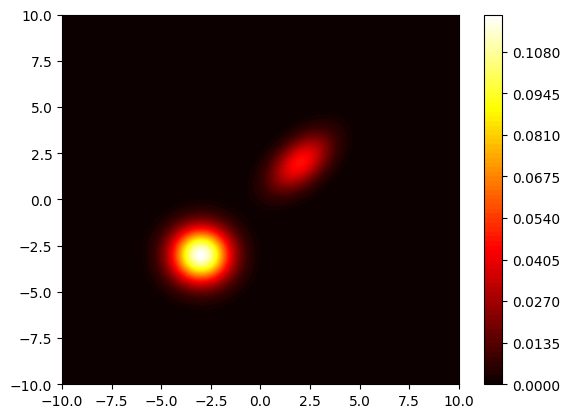

In [5]:
# Plot
plt.contourf(x1, x2, p_x, 100, cmap="hot")
plt.colorbar()

In [6]:
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x / p_x.sum(), 100, cmap="hot")

    # Init the solution
    x_samp = sampler.x_old

    # Run the optimization algorithm
    count = 0  # calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp, x), 0)

    ax.scatter(x_samp[:, 0], x_samp[:, 1], marker="+")

    # add AR (Acceptance Rate) to the title.
    ax.set_title(title + " AR={:.2f}".format(count / num_epochs))

### Metropolis-Hastings algorithm

In [7]:
class MetropolisHastings(object):
    def __init__(self, x, prob, std=0.1):
        self.prob = prob # prob dist
        self.std = std # sd
        self.x_old = x # original value

    def proposal(self, x):
        # choose new value from the normal distribution and given std
        x_new = np.random.normal(x,self.std)
        return x_new

    def evaluate(self, x_new, x_old):
        # Calculate the acceptance probability
        A = self.prob(x_new)/self.prob(x_old)
        return np.minimum(1.0, A) # 1.0 cuz 100%

    def select(self, x_new, A):
       # decide to keep or reject the new value
        u = np.random.uniform()
        if A > u:
            self.x_old = x_new
            return x_new
        else:
            return self.x_old

    def step(self):
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

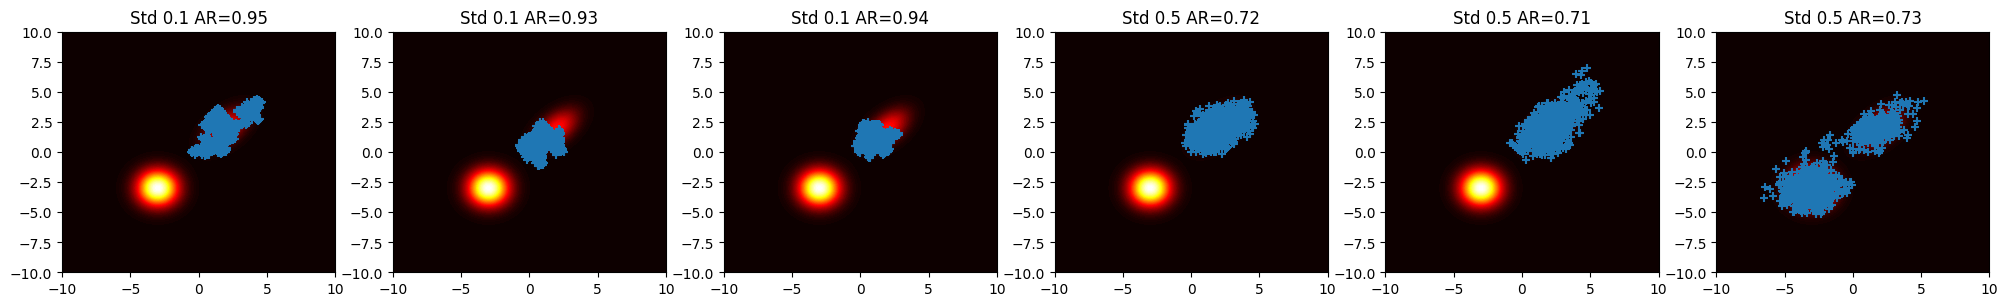

In [8]:
num_epochs = 1500  # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]  # repeat experiments 3 times per std

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1, len(stds), figsize=(20, 3))
fig_mh.tight_layout()

# start with the same point
x_init = np.asarray([[0.0, 0.0]])

for i in range(len(stds)):
    # take the std
    std = stds[i]
    # init the MH
    mh = MetropolisHastings(x=x_init, prob=prob, std=std)
    # plot the convergence
    plot_sampling_process(axs[i], sampler=mh, title="Std " + str(mh.std))

### Simulated Annealing (SA)

In [9]:
class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1.0, C=1.0):
        self.prob = prob # prob dist
        self.std = std # standard deviation
        self.x_old = x # initial solution
        self.T0 = T0 # initial temperature
        self.C = C # cooling parameter
        self.t = 0  # cooling scheme

    def proposal(self, x):
        # choose new value from the normal distribution and given std
        x_new = np.random.normal(x,self.std)
        return x_new

    def evaluate(self, x_new, x_old, T):
        # calc acceptance probability based on the proability dist
        A = (self.prob(x_new)**(1/T))/(self.prob(x_old)**(1/T))
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        # if random acceptance prob higher than random value, new value accepted
        u = np.random.uniform()
        if A > u:
            self.x_old = x_new
            return x_new
        else:
            return self.x_old


    def step(self):
        T = 1/(self.C * np.log(self.t + self.T0))
        self.t = self.t + 1
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old, T)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

<ipython-input-9-d5558bed6087>:31: RuntimeWarning: divide by zero encountered in double_scalars
  T = 1/(self.C * np.log(self.t + self.T0))


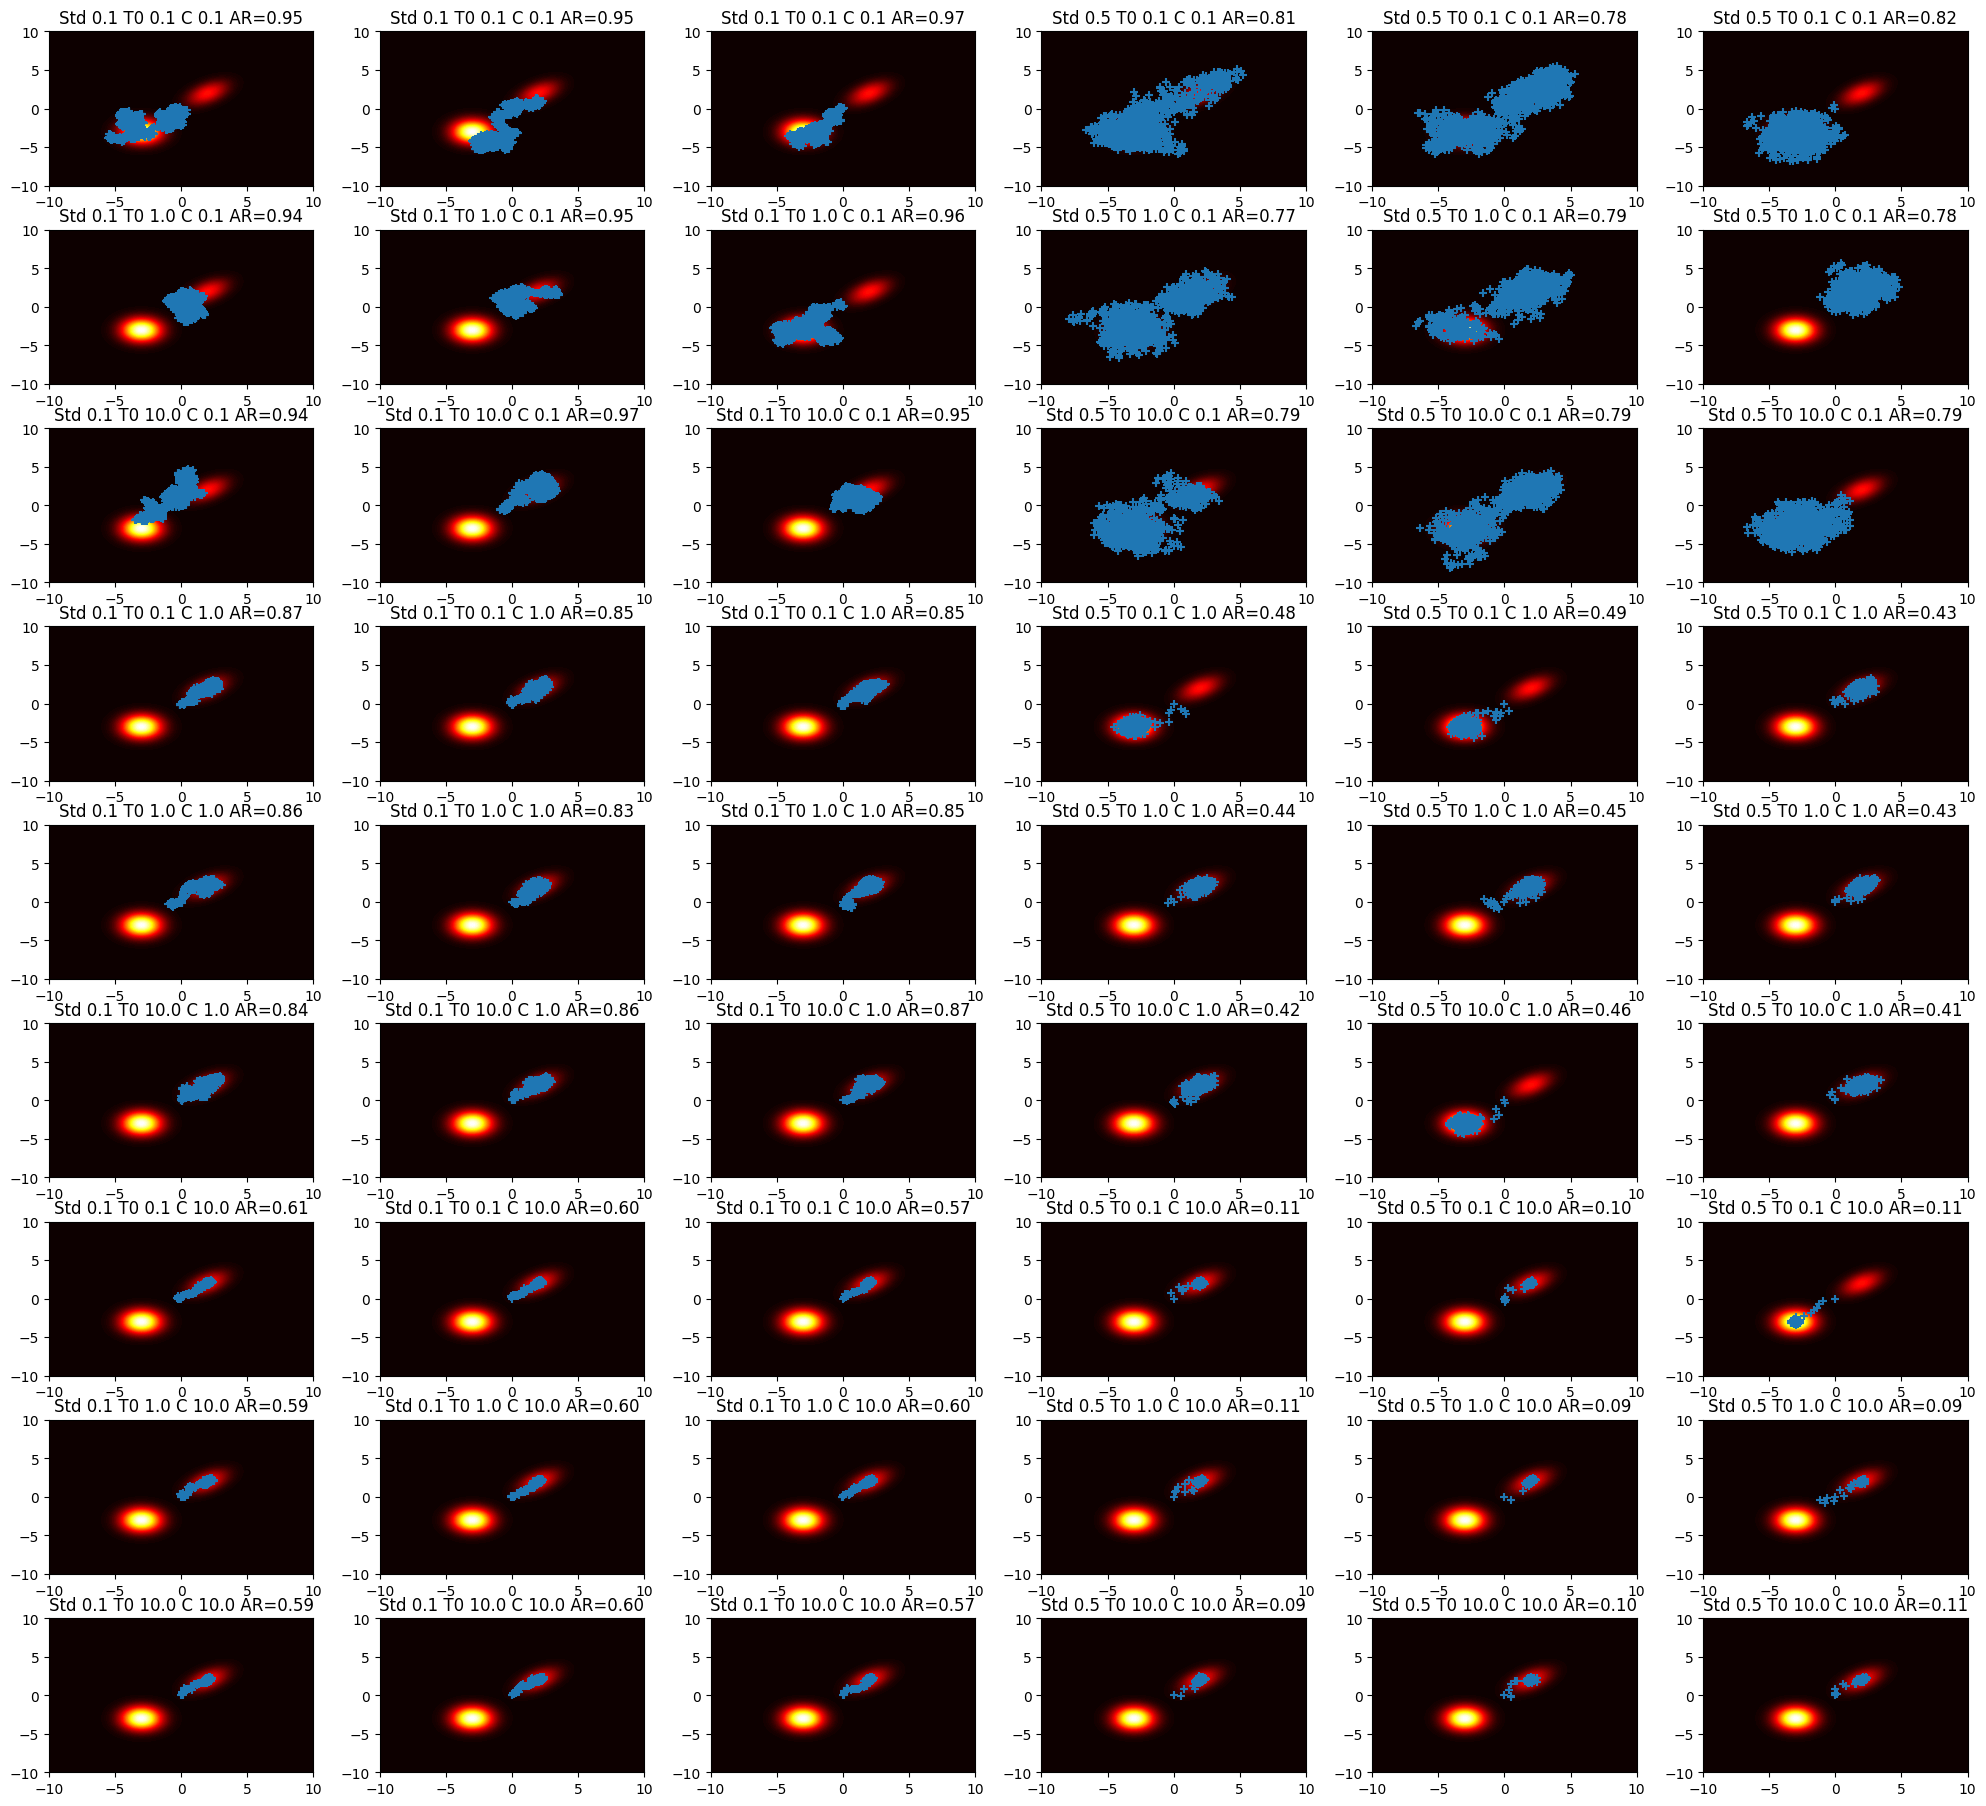

In [10]:
num_epochs = 1500  # the number of epochs
stds_sa = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]  # values of std repeat them due to randomness
T0s = [0.1, 1.0, 10.0]  # values of initial temperature
Cs = [0.1, 1.0, 10.0]  # values of cooling parameter

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s), len(stds_sa), figsize=(20, 18))
fig_sa.tight_layout()

# start with the same point
x_init = np.asarray([[0.0, 0.0]])

# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
        # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(
                axs[len(T0s) * i + k, j],
                sampler=sa,
                title="Std " + str(sa.std) + " T0 " + str(T0) + " C " + str(C),
            )

**SA** --> higher standard deviation leads to larger steps in search

**T0** --> higher initial temperatures allows for acceptance of worse solutions. Helps exploration as it can get out of a local minima.

**C** --> higher cooling constant causes a faster decrease in temperature